# Visualising $T_g$

This notebook contains the advanced visualisation and analysis options available for files output from the 'Computing_Tg' notebook.

In [2]:
import k3d
import matplotlib.pyplot as plt
import numpy as np

from mafiat.io import Reader
from mafiat.plot import plot_2d_map

Here we set options to increase plot readability.

In [3]:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 'large'

In [4]:
data = Reader()

In [5]:
data.read("../sample_data/sample.npz",
          vector_fields={"B": "face_staggered"})

Next we create an alias to the magnetic field data to avoid having to edit all of the references in the notebook when using different inputs.

In [6]:
data.mag_field = data.B

In [7]:
with np.load('../sample_data/sample_tg.npz', allow_pickle=True) as tg_data:
    tg_keys = tg_data.keys()
    locals().update(tg_data)

Next we display which variables were just set for reference purposes.

In [8]:
list(tg_keys)

['coords',
 'order',
 'Tw_step_5',
 'fr_defining_points',
 'axis_seed',
 'axis_coordinates',
 'rotsens',
 'Bhat',
 'Vhat',
 'BdV',
 'indexes',
 'fl_crds',
 'Tg',
 'Tg_comps',
 'ccolors',
 'clevels']

# Basic Flux Rope Visualisation

Here we create a basic visualisation of the flux rope as done in the computation notebook. No new tracing is performed.

In [9]:
vis = k3d.plot(grid_auto_fit=False, 
               grid=(data.mesh.indomain_extent.x[0]/1e6, data.mesh.indomain_extent.y[0]/1e6, data.mesh.indomain_extent.z[0]/1e6, 
                     data.mesh.indomain_extent.x[-1]/1e6, data.mesh.indomain_extent.y[-1]/1e6, data.mesh.indomain_extent.z[-1]/1e6))

In [10]:
plot_Bz_bottom = k3d.texture(attribute=1e4*data.mag_field.data[2][2:-2, 2:-2, 5].T,
                             bounds=(data.mesh.indomain_extent.x[0]/1e6, data.mesh.indomain_extent.x[-1]/1e6, 
                                     data.mesh.indomain_extent.y[0]/1e6, data.mesh.indomain_extent.y[-1]/1e6),
                             color_map=k3d.colormaps.matplotlib_color_maps.Gray,
                             color_range=[-1000, 1000])
vis += plot_Bz_bottom

In [11]:
axis_field_line \
    = k3d.line(np.dstack(axis_coordinates)[0].astype(np.float32)/1e6, 
               shader='mesh', width=1.0, color=0xaaaaaa)
axis_field_line.width = 6.0
vis += axis_field_line

Note that here the step size in the for loop can be reduced to include more lines.

In [12]:
field_lines = list()
np.random.seed(24390)
for i in range(0, len(fl_crds)-1, 50):
    field_lines.append(k3d.line(np.dstack(fl_crds[i])[0].astype(np.float32)/1e6, 
                                shader='mesh', width=1.0))
    field_lines[-1].color = np.random.randint(100, 0xffffff)
    vis += field_lines[-1]


In [13]:
vis.display()

Output()

# Basic $T_g$ Visualisation

Here we create plots of $T_g$ and $T_w$ side by side in the plane originally defined at the start of the computation notebook. First we create the appropriate 2D plane from the $T_g$ results.

In [14]:
shape = (len(coords[order[0]]), len(coords[order[1]]))
pTg = np.zeros(shape)
seeds = fr_defining_points
for k in range(len(seeds)):
    i = np.abs(seeds[k][order[0]] - coords[order[0]]).argmin()
    j = np.abs(seeds[k][order[1]] - coords[order[1]]).argmin()
    pTg[i,j] = Tg[k]

Next we adjust the coordinates such that area beyond the edges of the flux rope is cut out to facilitate easier comparison.

In [15]:
zoom_limits = np.where(pTg != 0)
zoom_pTg = np.copy(pTg)
zoom_pTg = zoom_pTg[min(zoom_limits[0]-1):max(zoom_limits[0]+2),
                    min(zoom_limits[1]-1):max(zoom_limits[1]+2)]
zoom_x_crds = np.copy(coords[order[0]])
zoom_x_crds = zoom_x_crds[min(zoom_limits[0]-1):max(zoom_limits[0]+2)]
zoom_y_crds = np.copy(coords[order[1]])
zoom_y_crds = zoom_y_crds[min(zoom_limits[1]-1):max(zoom_limits[1]+2)]
zoom_pTw = np.copy(Tw_step_5)
zoom_pTw = zoom_pTw[min(zoom_limits[0]-1):max(zoom_limits[0]+2),
                    min(zoom_limits[1]-1):max(zoom_limits[1]+2)]
axis_point = (np.abs(zoom_x_crds - axis_seed[order[0]]).argmin(),
              np.abs(zoom_y_crds - axis_seed[order[1]]).argmin())

Here we create the plot itself. Note that clevels and ccolors are read from the save file by default but can be re-defined as necessary.

Note that because the axis point was defined on a higher-resolution grid, it may appear slightly offset below. This is being considered for future versions.

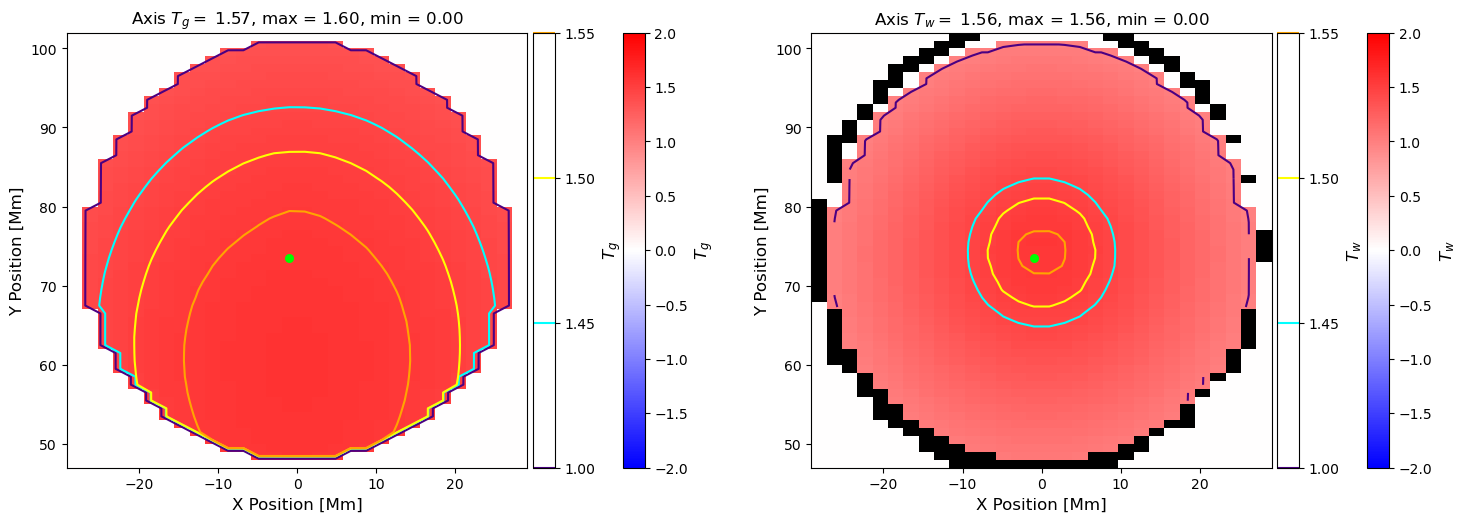

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmap = plt.get_cmap('bwr').copy()
cmap.set_bad(color='black') # Make NaN values appear black.

clevels = (1.0, 1.45, 1.5, 1.55)
clim = (-2.0, 2.0)
plot_2d_map(zoom_pTg, crds=(zoom_x_crds, zoom_y_crds), clim=clim, cmap=cmap, clabel='$T_g$', ax=ax1)
plot_2d_map(zoom_pTw, crds=(zoom_x_crds, zoom_y_crds), clim=clim, cmap=cmap, clabel='$T_w$', ax=ax2)

p1c = ax1.contour(zoom_x_crds/1e6, zoom_y_crds/1e6, zoom_pTg.T, levels=clevels, colors=ccolors)
cbar1 = fig.colorbar(p1c, pad=0.01, ax=ax1)
cbar1.set_label('$T_g$')
p2c = ax2.contour(zoom_x_crds/1e6, zoom_y_crds/1e6, zoom_pTw.T, levels=clevels, colors=ccolors)
cbar2 = fig.colorbar(p2c, pad=0.01, ax=ax2)
cbar2.set_label('$T_w$')
ax1.set_title('Axis $T_g = $ {:.2f}, max = {:.2f}, min = {:.2f}'.format(zoom_pTg[axis_point[0],axis_point[1]], np.nanmax(zoom_pTg), np.nanmin(zoom_pTg)))
ax2.set_title('Axis $T_w = $ {:.2f}, max = {:.2f}, min = {:.2f}'.format(zoom_pTw[axis_point[0],axis_point[1]], np.nanmax(zoom_pTw), np.nanmin(zoom_pTw)))
ax1.scatter(zoom_x_crds[axis_point[0]]/1e6, zoom_y_crds[axis_point[1]]/1e6, s=30, c='lime')
ax2.scatter(zoom_x_crds[axis_point[0]]/1e6, zoom_y_crds[axis_point[1]]/1e6, s=30, c='lime')
fig.tight_layout()

# Flux Rope Visualisation - Colouring Based on $T_g$

Here each segment of the field lines are coloured based on how much that segment contributes to the total $T_g$ integral.

In [25]:
vis2 = k3d.plot(grid_auto_fit=False, 
                grid=(data.mesh.indomain_extent.x[0]/1e6, data.mesh.indomain_extent.y[0]/1e6, data.mesh.indomain_extent.z[0]/1e6, 
                      data.mesh.indomain_extent.x[-1]/1e6, data.mesh.indomain_extent.y[-1]/1e6, data.mesh.indomain_extent.z[-1]/1e6))

In [26]:
plot_Bz_bottom = k3d.texture(attribute=1e4*data.mag_field.data[2][2:-2, 2:-2, 5].T,
                             bounds=(data.mesh.indomain_extent.x[0]/1e6, data.mesh.indomain_extent.x[-1]/1e6, 
                                     data.mesh.indomain_extent.y[0]/1e6, data.mesh.indomain_extent.y[-1]/1e6),
                             color_map=k3d.colormaps.matplotlib_color_maps.Gray,
                             color_range=[-1000, 1000])
vis2 += plot_Bz_bottom

In [27]:
axis_field_line \
    = k3d.line(np.dstack(axis_coordinates)[0].astype(np.float32)/1e6, 
               shader='mesh', width=1.0, color=0xaaaaaa)
axis_field_line.width = 6.0
vis2 += axis_field_line

Here we determine the limits for the field line colours based on $T_g$ and then plot each field line based on the tracing in the computation notebook.

In [28]:
Tg_limits = [np.nanmin(Tg_comps), np.nanmax(Tg_comps)]

In [29]:
field_lines = []
for i in range(0, len(fr_defining_points)-1, 20):
    
    field_line_crds = (np.array(fl_crds[i][0])[indexes[i]], 
                       np.array(fl_crds[i][1])[indexes[i]],
                       np.array(fl_crds[i][2])[indexes[i]])

    field_lines.append(k3d.line(np.dstack(field_line_crds)[0].astype(np.float32)/1e6, 
                                shader='mesh', width=1.0, 
                                color_map=k3d.basic_color_maps.Reds,
                                attribute=Tg_comps[i],
                                color_range=Tg_limits))
    vis2 += field_lines[-1]

Now we display the plot. Lines that are solid red have $T_g$ = NaN. To get the $T_g$ colourbar go to the 'K3D panel' in the top right of the plot, click 'Objects', then 'Line #2', and then tick the 'colorLegend' box.

In [30]:
vis2.display()

Output()